# Data Analysis and Visualization of Cursor Accuracy with Tremor Identification

This code was developed to analyze data and generate figures for "Evaluating Mouse Control and Usability Patterns Across Tremor and Non-Tremor Populations"

### Loading necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Combining Mouse Click Accuracy and Tremor Data

In [2]:
# XY cursor targets for tasks
targets = pd.read_csv("./targets.csv")
targets = targets[['X', 'Y']]

# tremor status of participants
tremors = pd.read_csv('../survey analysis/survey_results_text.csv', skiprows=1, header=0)
tremors = tremors[tremors['participant_ID']!='SURVEY TEST']
tremors = tremors[['participant_ID', 'tremor_level']]

In [3]:
# Create dataframe with distance of mouse click from target in pixels
off_targets = pd.DataFrame({'participant_ID': [], 'off_target_distance': []})

for i in range(50):
    if os.path.exists("./data/positions_" + str(i) + ".txt"):
        # Cursor Data
        cursor = pd.read_csv("./data/positions_" + str(i) + ".txt", sep='\t', header=None, names=['time', 'X', 'Y'])
        clicks = cursor[cursor['time'] == 'Mouse Click'].index
        clicks = cursor.loc[clicks-1]
        clicks.reset_index(inplace=True)
        clicks = clicks[['X', 'Y']]

        x_dis = clicks['X']-targets['X']
        y_dis = clicks['Y']-targets['Y']

        for j in range(len(x_dis)):
            off_targets.loc[len(off_targets)] = ['PT' + str(i).zfill(2), np.mean(np.sqrt(x_dis[j]**2 + y_dis[j]**2))]

# Merge the data
click_accuracy = pd.merge(tremors, off_targets, on='participant_ID')

## Mixed-Effects Model of Task Click Accuracy

In [4]:
# Fit a linear mixed-effects model
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf

model = smf.mixedlm("off_target_distance ~ C(tremor_level)", data=click_accuracy, groups=click_accuracy["participant_ID"])
result = model.fit()
print(result.summary())

                   Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    off_target_distance
No. Observations:      1008       Method:                REML               
No. Groups:            48         Scale:                 58588.2449         
Min. group size:       21         Log-Likelihood:        -6982.0276         
Max. group size:       21         Converged:             Yes                
Mean group size:       21.0                                                 
----------------------------------------------------------------------------
                              Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------------------
Intercept                      49.299   17.434  2.828 0.005   15.128  83.469
C(tremor_level)[T.Sometimes]  -18.430   43.710 -0.422 0.673 -104.100  67.240
C(tremor_level)[T.Yes]        218.824   55.817  3.920 0.000  109.425 328.223
Group Var          

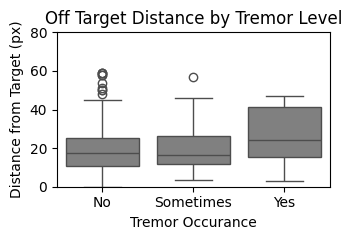

In [6]:
plt.figure(figsize=(3.5,2.5))

sns.boxplot(data=click_accuracy, x='tremor_level', y='off_target_distance', color='grey')
plt.ylim([0, 80])
plt.title('Off Target Distance by Tremor Level', fontsize=12)
plt.xlabel('Tremor Occurance')
plt.ylabel('Distance from Target (px)')
plt.tight_layout()
plt.savefig('distance_to_target.png', dpi=300, bbox_inches='tight')

## Mean Click Accuracy per Participant

### Combine Data Into One DataFrame

In [9]:
mean_click_accuracy = click_accuracy.groupby(['participant_ID', 'tremor_level'], as_index=False)['off_target_distance'].mean()

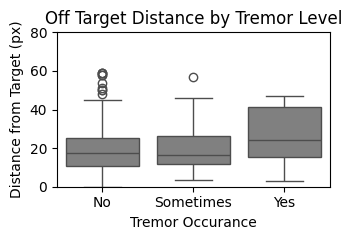

In [10]:
plt.figure(figsize=(3.5,2.5))

sns.boxplot(data=click_accuracy, x='tremor_level', y='off_target_distance', color='grey')
plt.ylim([0, 80])
plt.title('Off Target Distance by Tremor Level', fontsize=12)
plt.xlabel('Tremor Occurance')
plt.ylabel('Distance from Target (px)')
plt.tight_layout()
plt.savefig('distance_to_target.png', dpi=300, bbox_inches='tight')

In [11]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# One-way ANOVA: Score by tremor_level
anova_model = ols('off_target_distance ~ C(tremor_level)', data=mean_click_accuracy).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print(anova_table)


                        sum_sq    df         F    PR(>F)
C(tremor_level)  182310.015469   2.0  8.105126  0.000986
Residual         506096.435282  45.0       NaN       NaN


In [12]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Run Tukey’s test
tukey = pairwise_tukeyhsd(endog=mean_click_accuracy['off_target_distance'],
                          groups=mean_click_accuracy['tremor_level'],
                          alpha=0.05)

# Print summary table
print(tukey.summary())

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1    group2  meandiff p-adj    lower    upper   reject
-------------------------------------------------------------
       No Sometimes   -18.43 0.9069 -124.3676  87.5076  False
       No       Yes 218.8237 0.0009   83.5434 354.1041   True
Sometimes       Yes 237.2537 0.0024   76.1554 398.3521   True
-------------------------------------------------------------
